In [86]:
import numpy as np
import pandas as pd
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools
import matplotlib.pyplot as plt
import numpy as np


# Set random seed for reproducibility
np.random.seed(42)

# Define date range
dates = pd.date_range(start="2023-01-01", end="2023-12-31", freq="D")

# Generate a list of products
products = [f"Product_{i}" for i in range(1, 51)]

# Generate data
data = {
    "date": np.random.choice(dates, size=5000),
    "product_id": np.random.choice(products, size=5000),
    "category": np.random.choice(["Electronics", "Clothing", "Home Goods"], size=5000),
    "sales_quantity": np.random.poisson(lam=10, size=5000),  # Base sales volume
    "stock_remaining": np.random.randint(50, 500, size=5000),  # Simulated inventory level
    "location": np.random.choice(["Warehouse_A", "Warehouse_B", "Warehouse_C"], size=5000),
    "price": np.random.uniform(10, 500, size=5000).round(2),  # Product price
    "promotion": np.random.choice([0, 1], size=5000, p=[0.8, 0.2]),  # 20% on promotion
    "is_holiday": np.random.choice([0, 1], size=5000, p=[0.9, 0.1]),  # 10% holiday dates
}

# Create the DataFrame
df = pd.DataFrame(data)

# Add time-based features for forecasting
df["day_of_week"] = pd.to_datetime(df["date"]).dt.dayofweek  # 0=Monday, 6=Sunday
df["is_weekend"] = df["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)
df["month"] = pd.to_datetime(df["date"]).dt.month
df["quarter"] = pd.to_datetime(df["date"]).dt.quarter

# Simulate demand seasonality (e.g., higher sales in December)
df["sales_quantity"] += (df["month"] == 12).astype(int) * np.random.poisson(lam=5, size=len(df))

# Add reorder point and lead time
df["reorder_point"] = np.random.randint(20, 100, size=len(df))
df["lead_time"] = np.random.randint(2, 10, size=len(df))  # Days for restocking

# Sort by date for time-series analysis
df = df.sort_values(by=["product_id", "date"]).reset_index(drop=True)

# Save to CSV
df.to_csv("enhanced_inventory_forecasting_data.csv", index=False)

print("Synthetic dataset generated and saved as 'enhanced_inventory_forecasting_data.csv'")


Synthetic dataset generated and saved as 'enhanced_inventory_forecasting_data.csv'


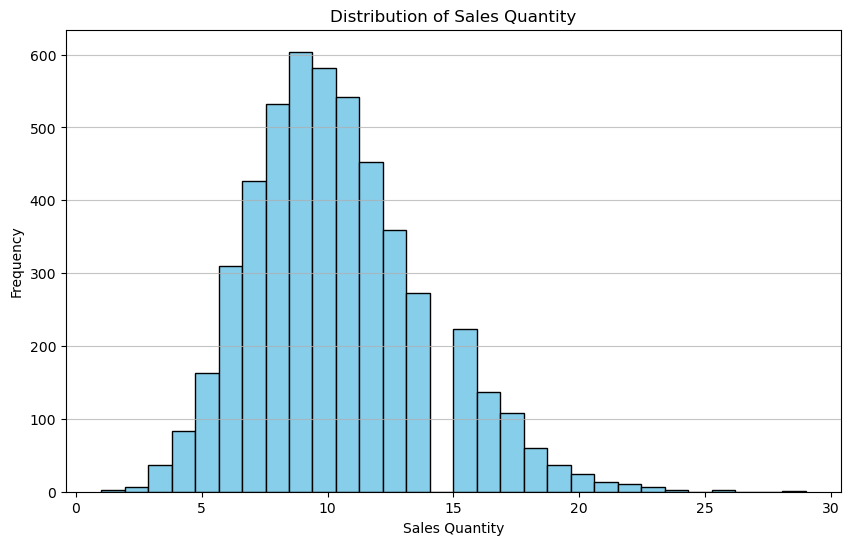

In [87]:
# Plot the distribution of sales_quantity
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df["sales_quantity"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Sales Quantity")
plt.xlabel("Sales Quantity")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Save the plot to images folder
plt.savefig("images/sales_quantity_distribution.png")

#plt.savefig("sales_quantity_distribution.png")




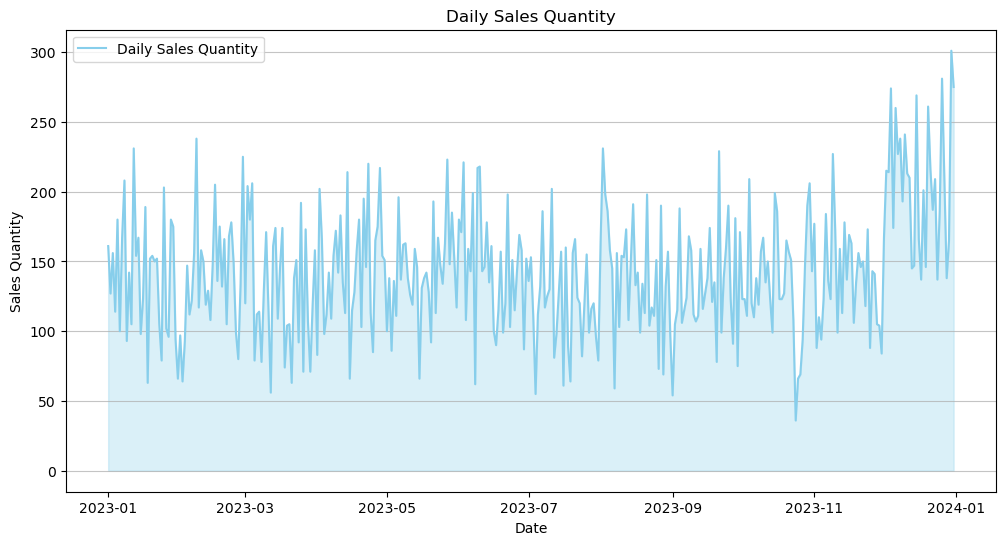

In [88]:
# Plot daily sales quantity
daily_sales = df.groupby("date")["sales_quantity"].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(daily_sales["date"], daily_sales["sales_quantity"], color="skyblue", label="Daily Sales Quantity")
plt.fill_between(daily_sales["date"], daily_sales["sales_quantity"], color="skyblue", alpha=0.3)
plt.title("Daily Sales Quantity")
plt.xlabel("Date")
plt.ylabel("Sales Quantity")
plt.grid(axis="y", alpha=0.75)
plt.legend()
plt.savefig("images/daily_sales_quantity.png")

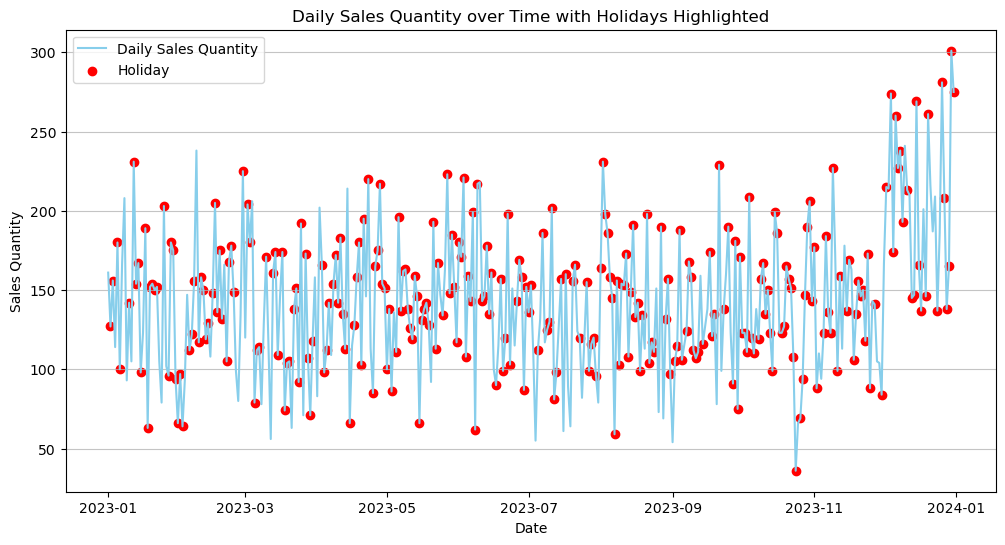

In [89]:
# Compare sales quantity during holidays vs. non-holidays

# Group by date and sum sales quantity
daily_sales = df.groupby("date")["sales_quantity"].sum().reset_index()
daily_sales["is_holiday"] = df.groupby("date")["is_holiday"].max().values


# Plot daily sales quantity
plt.figure(figsize=(12, 6))
plt.plot(daily_sales["date"], daily_sales["sales_quantity"], color="skyblue", label="Daily Sales Quantity")
plt.scatter(
    daily_sales[daily_sales["is_holiday"] == 1]["date"],
    daily_sales[daily_sales["is_holiday"] == 1]["sales_quantity"],
    color="red",
    label="Holiday",
)
plt.title("Daily Sales Quantity over Time with Holidays Highlighted")
plt.xlabel("Date")
plt.ylabel("Sales Quantity")
plt.legend()
plt.grid(axis="y", alpha=0.75)
plt.savefig("images/daily_sales_quantity_holidays.png")


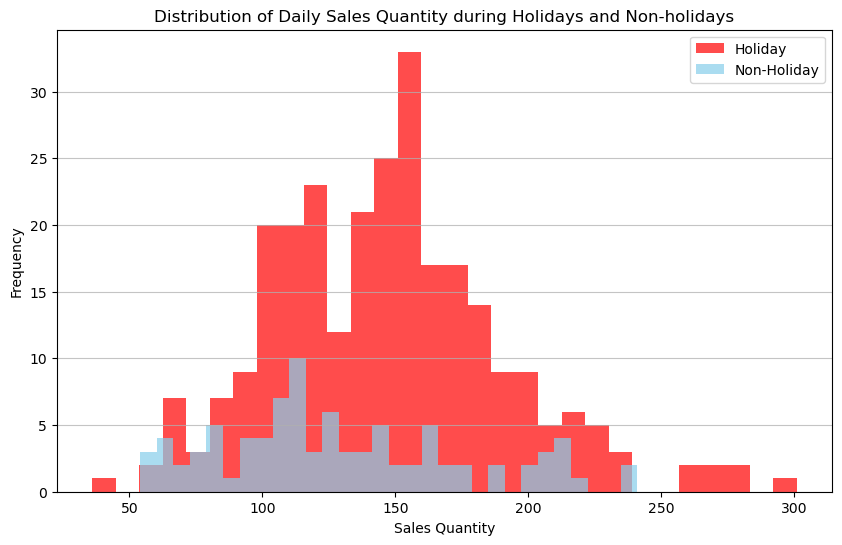

In [90]:
# Plot sales quantity and frequency during holidays vs. non-holidays

plt.figure(figsize=(10, 6))
plt.hist(daily_sales[daily_sales["is_holiday"] == 1]["sales_quantity"], bins=30, color="red", alpha=0.7, label="Holiday")
plt.hist(daily_sales[daily_sales["is_holiday"] == 0]["sales_quantity"], bins=30, color="skyblue", alpha=0.7, label="Non-Holiday")
plt.title("Distribution of Daily Sales Quantity during Holidays and Non-holidays")
plt.xlabel("Sales Quantity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis="y", alpha=0.75)
plt.savefig("images/daily_sales_quantity_holidays_distribution.png")


In [91]:
# Forecasting sales quantity using ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools

# Filter data for a specific product
product_id = "Product_1"
product_data = df[df["product_id"] == product_id].copy()

# Group by date and sum sales quantity
product_sales = product_data.groupby("date")["sales_quantity"].sum().reset_index()



In [92]:
# Train-test split
train_size = int(len(product_sales) * 0.8)
train_sales = product_sales[:train_size]["sales_quantity"]
test_sales = product_sales[train_size:]["sales_quantity"]

# Fit ARIMA model
model = ARIMA(train_sales, order=(5, 1, 0))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test_sales))
forecast_index = product_sales[train_size:].index

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_sales, forecast))

# Print RMSE
print(f"RMSE for ARIMA model on {product_id}: {rmse:.2f}")




RMSE for ARIMA model on Product_1: 3.64


In [93]:
# Ensure the date column is in datetime format
product_sales["date"] = pd.to_datetime(product_sales["date"])

# Convert the date index to monthly periods
product_sales["month"] = product_sales["date"].dt.to_period('M')

# Convert the month column to strings
product_sales["month_str"] = product_sales["month"].astype(str)

# Train-test split
train_size = int(len(product_sales) * 0.8)
train_sales = product_sales[:train_size]["sales_quantity"]
test_sales = product_sales[train_size:]["sales_quantity"]

# Function to evaluate ARIMA model
def evaluate_arima_model(train, test, arima_order):
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    rmse = np.sqrt(mean_squared_error(test, forecast))
    return rmse

# Grid search for ARIMA parameters
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)
best_score, best_cfg = float("inf"), None

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        rmse = evaluate_arima_model(train_sales, test_sales, (p, d, q))
        if rmse < best_score:
            best_score, best_cfg = rmse, (p, d, q)
    except:
        continue

print(f"Best ARIMA parameters: {best_cfg} with RMSE: {best_score:.2f}")

# Fit ARIMA model with best parameters
model = ARIMA(train_sales, order=best_cfg)
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test_sales))
forecast_index = product_sales[train_size:].index

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_sales, forecast))

# Print RMSE
print(f"RMSE for ARIMA model on {product_id}: {rmse:.2f}")


c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters foun

Best ARIMA parameters: (3, 2, 0) with RMSE: 3.17
RMSE for ARIMA model on Product_1: 3.17


c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


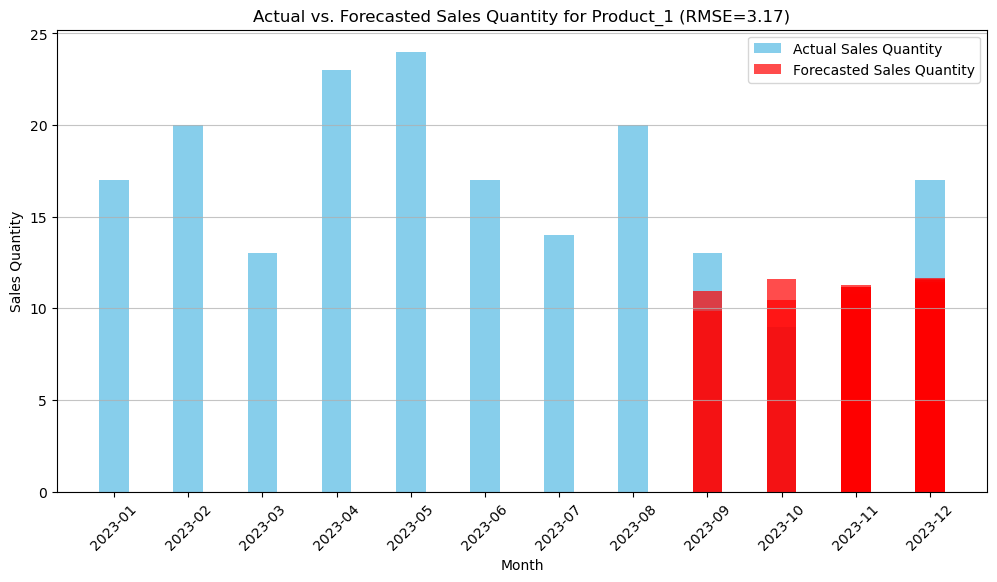

In [94]:
# Plot actual vs. forecasted sales quantity using a bar chart
plt.figure(figsize=(12, 6))
width = 0.4  # Width of the bars

# Plot actual sales quantities
plt.bar(product_sales["month_str"], product_sales["sales_quantity"], width=width, color="skyblue", label="Actual Sales Quantity")

# Plot forecasted sales quantities
forecast_months = product_sales["month_str"][train_size:]
plt.bar(forecast_months, forecast, width=width, color="red", alpha=0.7, label="Forecasted Sales Quantity")

plt.title(f"Actual vs. Forecasted Sales Quantity for {product_id} (RMSE={rmse:.2f})")
plt.xlabel("Month")
plt.ylabel("Sales Quantity")
plt.legend()
plt.grid(axis="y", alpha=0.75)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.savefig("images/arima_forecast_sales_quantity_bar.png")

In [95]:
# Forecasting sales for the entire year

# Ensure the date column is in datetime format
product_sales["date"] = pd.to_datetime(product_sales["date"])

# Convert the date index to monthly periods
product_sales["month"] = product_sales["date"].dt.to_period('M')

# Convert the month column to strings
product_sales["month_str"] = product_sales["month"].astype(str)

# Train-test split
train_size = int(len(product_sales) * 0.8)
train_sales = product_sales[:train_size]["sales_quantity"]
test_sales = product_sales[train_size:]["sales_quantity"]

# Function to evaluate ARIMA model
def evaluate_arima_model(train, test, arima_order):
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    rmse = np.sqrt(mean_squared_error(test, forecast))
    return rmse

# Grid search for ARIMA parameters
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)
best_score, best_cfg = float("inf"), None

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        rmse = evaluate_arima_model(train_sales, test_sales, (p, d, q))
        if rmse < best_score:
            best_score, best_cfg = rmse, (p, d, q)
    except:
        continue

print(f"Best ARIMA parameters: {best_cfg} with RMSE: {best_score:.2f}")

# Fit ARIMA model with best parameters
model = ARIMA(train_sales, order=best_cfg)
model_fit = model.fit()

# Forecast for the test period
test_forecast = model_fit.forecast(steps=len(test_sales))

# Calculate RMSE for the test period
rmse = np.sqrt(mean_squared_error(test_sales, test_forecast))

# Print RMSE
print(f"RMSE for ARIMA model on {product_id}: {rmse:.2f}")

# Forecast for the entire year
forecast_steps = 12  # Number of months in a year
year_forecast = model_fit.forecast(steps=forecast_steps)

# Create a date range for the forecast
forecast_dates = pd.date_range(start=product_sales["date"].max() + pd.Timedelta(days=1), periods=forecast_steps, freq='M')
forecast_months = forecast_dates.to_period('M').astype(str)




c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters foun

Best ARIMA parameters: (3, 2, 0) with RMSE: 3.17
RMSE for ARIMA model on Product_1: 3.17


c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\a3588\AppData\Local\Temp\ipykernel_12556\1715084308.py:59: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=product_sales["date"].max() + pd.Timedelta(days=1), periods=forecast_steps, freq='M')


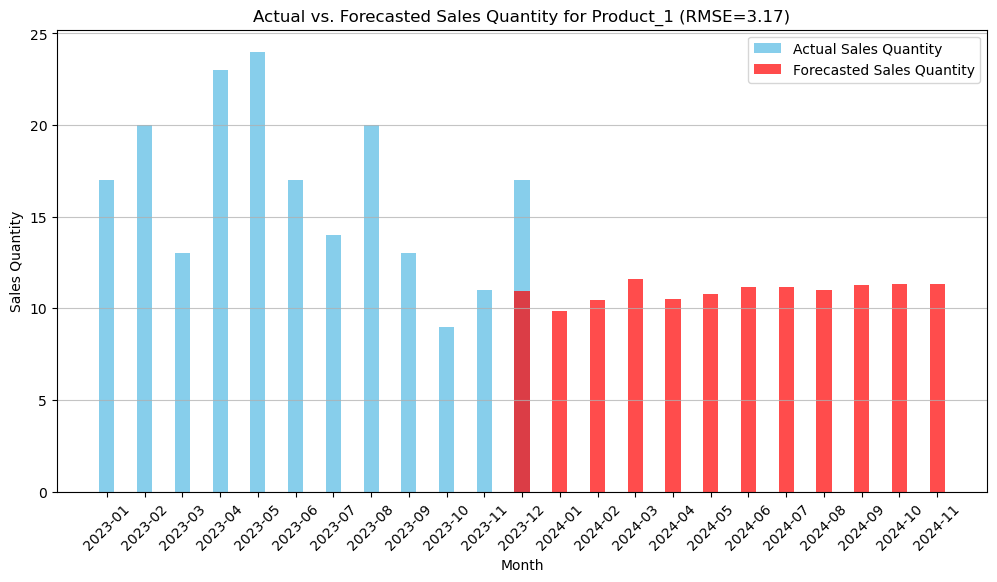

In [96]:
# Plot actual vs. forecasted sales quantity using a bar chart
plt.figure(figsize=(12, 6))
width = 0.4  # Width of the bars

# Plot actual sales quantities
plt.bar(product_sales["month_str"], product_sales["sales_quantity"], width=width, color="skyblue", label="Actual Sales Quantity")

# Plot forecasted sales quantities for the entire year
plt.bar(forecast_months, year_forecast, width=width, color="red", alpha=0.7, label="Forecasted Sales Quantity")

plt.title(f"Actual vs. Forecasted Sales Quantity for {product_id} (RMSE={rmse:.2f})")
plt.xlabel("Month")
plt.ylabel("Sales Quantity")
plt.legend()
plt.grid(axis="y", alpha=0.75)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.savefig("images/arima_forecast_sales_quantity_bar.png")

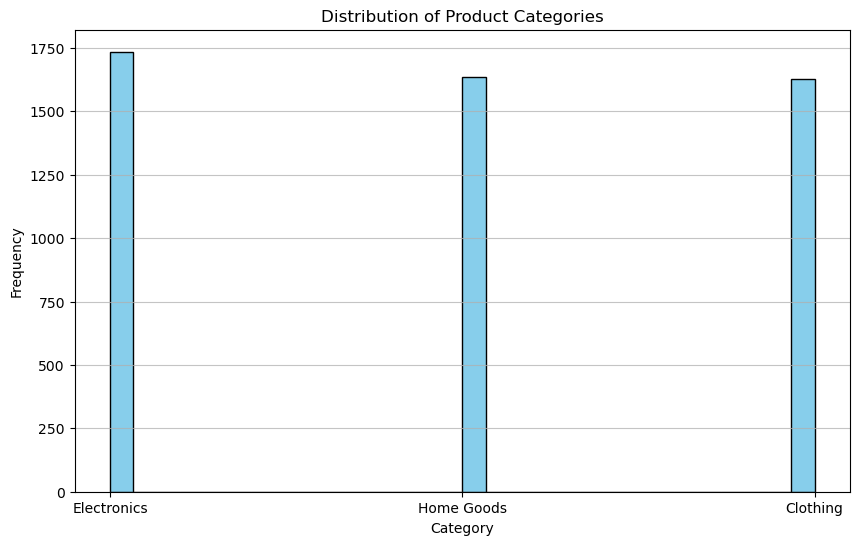

In [97]:
# Plot the distribution of categories
plt.figure(figsize=(10, 6))
plt.hist(df["category"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Product Categories")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.savefig("images/category_distribution.png")



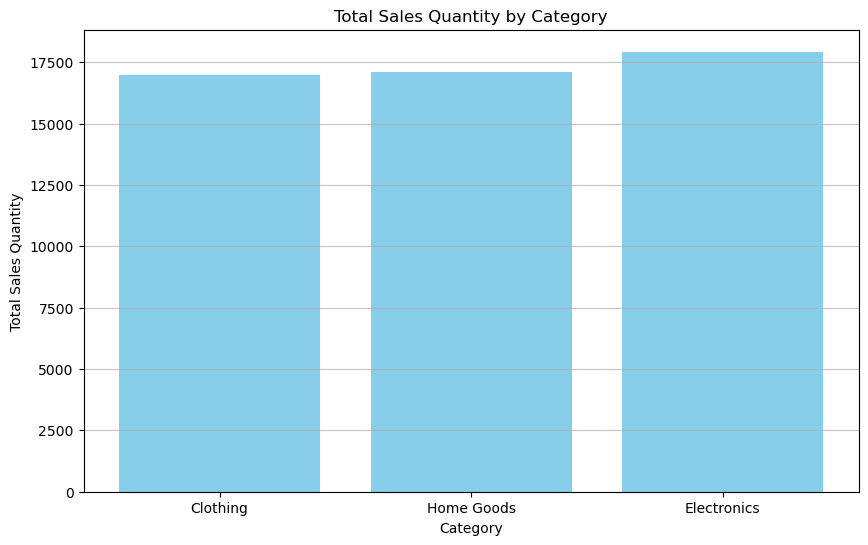

In [98]:
# Compare sales quantity across categories
category_sales = df.groupby("category")["sales_quantity"].sum().sort_values()

plt.figure(figsize=(10, 6))
plt.bar(category_sales.index, category_sales.values, color="skyblue")
plt.title("Total Sales Quantity by Category")
plt.xlabel("Category")
plt.ylabel("Total Sales Quantity")
plt.grid(axis="y", alpha=0.75)
plt.savefig("images/category_sales_quantity.png")



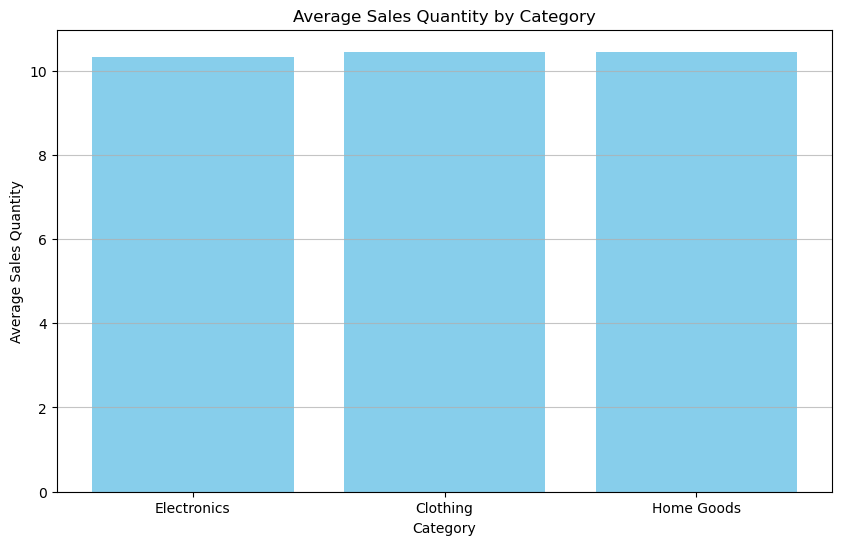

In [99]:
# Compare average sales quantity across categories
category_avg_sales = df.groupby("category")["sales_quantity"].mean().sort_values()

plt.figure(figsize=(10, 6))
plt.bar(category_avg_sales.index, category_avg_sales.values, color="skyblue")
plt.title("Average Sales Quantity by Category")
plt.xlabel("Category")
plt.ylabel("Average Sales Quantity")
plt.grid(axis="y", alpha=0.75)
plt.savefig("images/category_avg_sales_quantity.png")



<Figure size 1200x600 with 0 Axes>

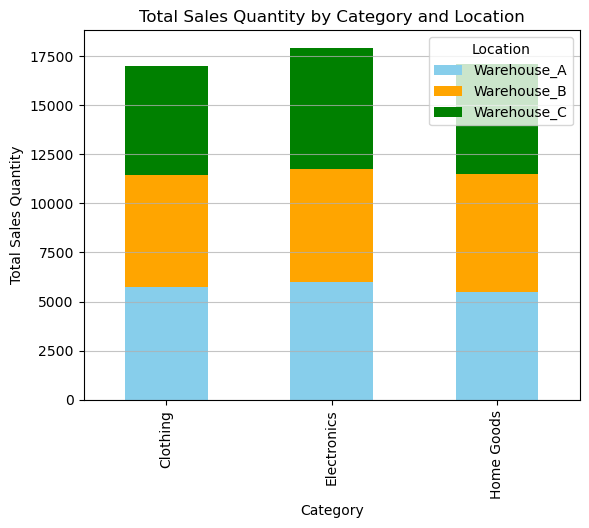

In [100]:
# Compare sales quantity across categories and locations
category_location_sales = df.groupby(["category", "location"])["sales_quantity"].sum().unstack()

plt.figure(figsize=(12, 6))
category_location_sales.plot(kind="bar", stacked=True, color=["skyblue", "orange", "green"])
plt.title("Total Sales Quantity by Category and Location")
plt.xlabel("Category")
plt.ylabel("Total Sales Quantity")
plt.grid(axis="y", alpha=0.75)
plt.legend(title="Location")
plt.savefig("images/category_location_sales_quantity.png")


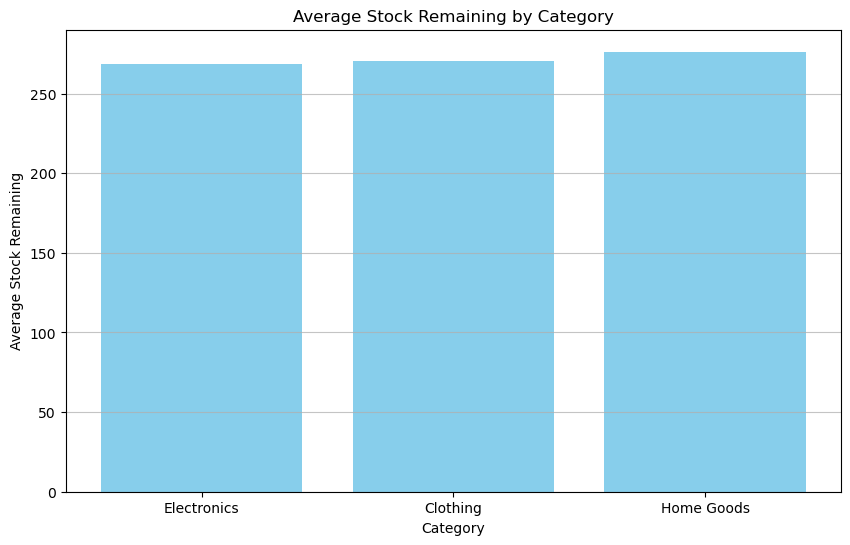

In [101]:
# Compare stock remaining across categories
category_stock = df.groupby("category")["stock_remaining"].mean().sort_values()

plt.figure(figsize=(10, 6))
plt.bar(category_stock.index, category_stock.values, color="skyblue")
plt.title("Average Stock Remaining by Category")
plt.xlabel("Category")
plt.ylabel("Average Stock Remaining")
plt.grid(axis="y", alpha=0.75)

plt.savefig("images/category_avg_stock_remaining.png")


<Figure size 1200x600 with 0 Axes>

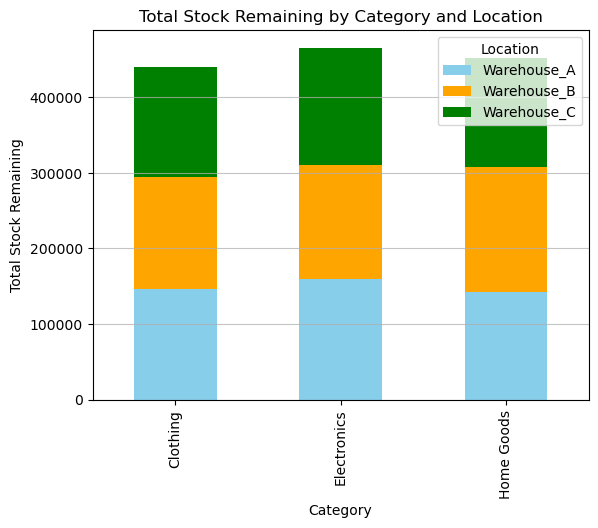

In [102]:
# Compare stock remaining across categories and locations
category_location_stock = df.groupby(["category", "location"])["stock_remaining"].sum().unstack()

plt.figure(figsize=(12, 6))
category_location_stock.plot(kind="bar", stacked=True, color=["skyblue", "orange", "green"])
plt.title("Total Stock Remaining by Category and Location")
plt.xlabel("Category")
plt.ylabel("Total Stock Remaining")
plt.grid(axis="y", alpha=0.75)
plt.legend(title="Location")

plt.savefig("images/category_location_stock_remaining.png")



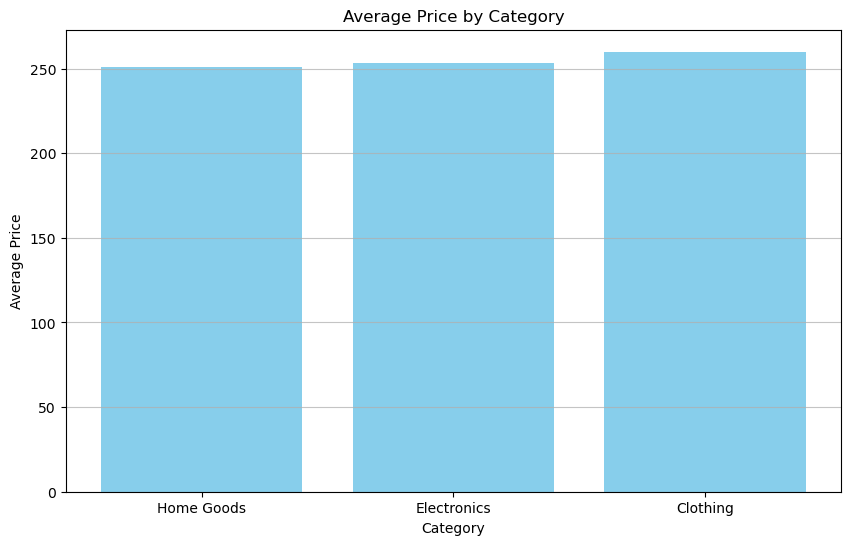

In [103]:
# Compare average price across categories
category_price = df.groupby("category")["price"].mean().sort_values()

plt.figure(figsize=(10, 6))
plt.bar(category_price.index, category_price.values, color="skyblue")
plt.title("Average Price by Category")
plt.xlabel("Category")
plt.ylabel("Average Price")
plt.grid(axis="y", alpha=0.75)

plt.savefig("images/category_avg_price.png")

In [104]:
# Forecast sales quantity for Home Goods category using ARIMA
category = "Home Goods"
category_data = df[df["category"] == category].copy()

# Group by date and sum sales quantity
category_sales = category_data.groupby("date")["sales_quantity"].sum().reset_index()

# Ensure the date column is in datetime format
category_sales["date"] = pd.to_datetime(category_sales["date"])

# Convert the date index to monthly periods
category_sales["month"] = category_sales["date"].dt.to_period('M')

# Convert the month column to strings
category_sales["month_str"] = category_sales["month"].astype(str)





In [105]:
# Train-test split
train_size = int(len(category_sales) * 0.8)
train_sales = category_sales[:train_size]["sales_quantity"]
test_sales = category_sales[train_size:]["sales_quantity"]

# Function to evaluate ARIMA model
def evaluate_arima_model(train, test, arima_order):
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    rmse = np.sqrt(mean_squared_error(test, forecast))
    return rmse

# Grid search for ARIMA parameters
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)
best_score, best_cfg = float("inf"), None

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        rmse = evaluate_arima_model(train_sales, test_sales, (p, d, q))
        if rmse < best_score:
            best_score, best_cfg = rmse, (p, d, q)
    except:
        continue

print(f"Best ARIMA parameters for {category}: {best_cfg} with RMSE: {best_score:.2f}")

# Fit ARIMA model with best parameters
model = ARIMA(train_sales, order=best_cfg)
model_fit = model.fit()

# Forecast for the test period
test_forecast = model_fit.forecast(steps=len(test_sales))

# Calculate RMSE for the test period
rmse = np.sqrt(mean_squared_error(test_sales, test_forecast))

# Print RMSE
print(f"RMSE for ARIMA model on {category}: {rmse:.2f}")

c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters foun

Best ARIMA parameters for Home Goods: (2, 2, 0) with RMSE: 23.93
RMSE for ARIMA model on Home Goods: 23.93


c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


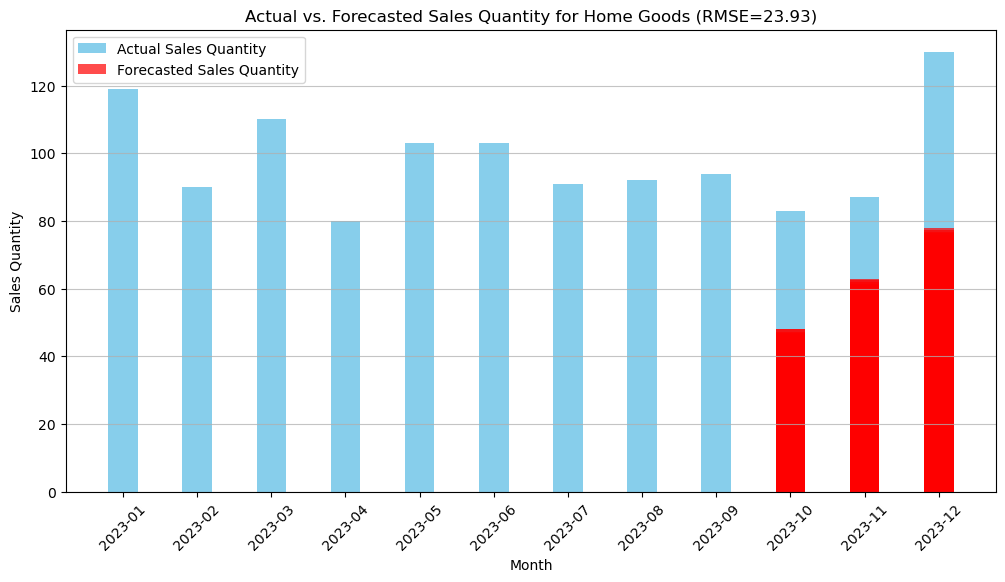

In [106]:
# Plot actual vs. forecasted sales quantity for Home Goods using a bar chart
plt.figure(figsize=(12, 6))
width = 0.4  # Width of the bars

# Plot actual sales quantities
plt.bar(category_sales["month_str"], category_sales["sales_quantity"], width=width, color="skyblue", label="Actual Sales Quantity")

# Plot forecasted sales quantities for the entire year
plt.bar(category_sales["month_str"][train_size:], test_forecast, width=width, color="red", alpha=0.7, label="Forecasted Sales Quantity")

plt.title(f"Actual vs. Forecasted Sales Quantity for {category} (RMSE={rmse:.2f})")
plt.xlabel("Month")
plt.ylabel("Sales Quantity")
plt.legend()
plt.grid(axis="y", alpha=0.75)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.savefig("images/arima_forecast_sales_quantity_home_goods.png")



C:\Users\a3588\AppData\Local\Temp\ipykernel_12556\2501230784.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=category_sales["date"].max() + pd.Timedelta(days=1), periods=forecast_steps, freq='M')


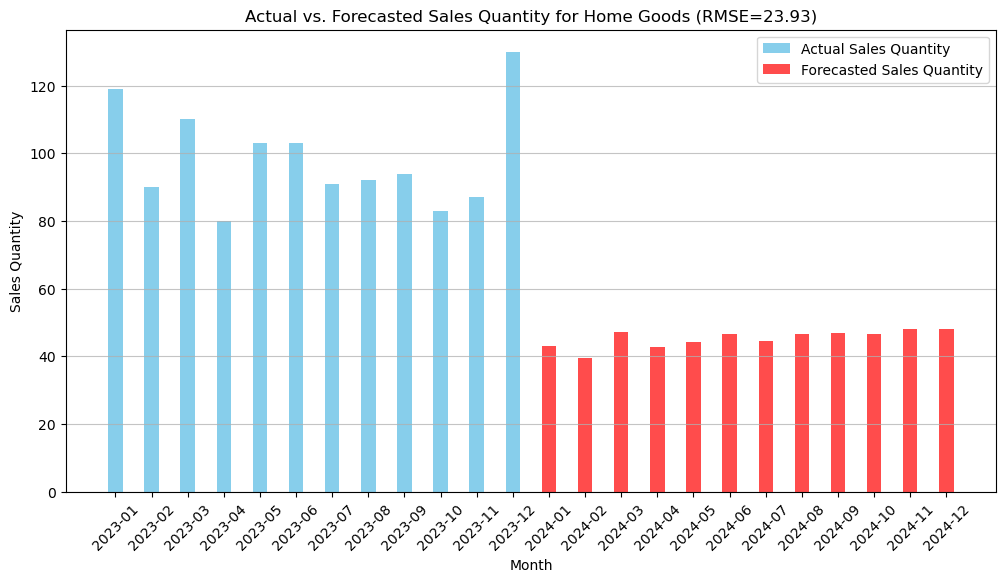

In [107]:
# Forecast for the entire year
forecast_steps = 12  # Number of months in a year
year_forecast = model_fit.forecast(steps=forecast_steps)

# Create a date range for the forecast
forecast_dates = pd.date_range(start=category_sales["date"].max() + pd.Timedelta(days=1), periods=forecast_steps, freq='M')
forecast_months = forecast_dates.to_period('M').astype(str)

# Plot actual vs. forecasted sales quantity for Home Goods using a bar chart
plt.figure(figsize=(12, 6))
width = 0.4  # Width of the bars

# Plot actual sales quantities
plt.bar(category_sales["month_str"], category_sales["sales_quantity"], width=width, color="skyblue", label="Actual Sales Quantity")

# Plot forecasted sales quantities for the entire year
plt.bar(forecast_months, year_forecast, width=width, color="red", alpha=0.7, label="Forecasted Sales Quantity")

plt.title(f"Actual vs. Forecasted Sales Quantity for {category} (RMSE={rmse:.2f})")
plt.xlabel("Month")
plt.ylabel("Sales Quantity")
plt.legend()
plt.grid(axis="y", alpha=0.75)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.savefig("images/arima_forecast_sales_quantity_home_goods_year.png")


In [108]:
# # Forecast sales quantity for Clothing category using ARIMA
category = "Clothing"
category_data = df[df["category"] == category].copy()

# Group by date and sum sales quantity
category_sales = category_data.groupby("date")["sales_quantity"].sum().reset_index()

# Ensure the date column is in datetime format
category_sales["date"] = pd.to_datetime(category_sales["date"])

# Convert the date index to monthly periods
category_sales["month"] = category_sales["date"].dt.to_period('M')

# Convert the month column to strings
category_sales["month_str"] = category_sales["month"].astype(str)




In [109]:
# Train-test split
train_size = int(len(category_sales) * 0.8)
train_sales = category_sales[:train_size]["sales_quantity"]
test_sales = category_sales[train_size:]["sales_quantity"]

# Function to evaluate ARIMA model
def evaluate_arima_model(train, test, arima_order):
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    rmse = np.sqrt(mean_squared_error(test, forecast))
    return rmse

# Grid search for ARIMA parameters
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)
best_score, best_cfg = float("inf"), None

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        rmse = evaluate_arima_model(train_sales, test_sales, (p, d, q))
        if rmse < best_score:
            best_score, best_cfg = rmse, (p, d, q)
    except:
        continue

print(f"Best ARIMA parameters for {category}: {best_cfg} with RMSE: {best_score:.2f}")




c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters foun

Best ARIMA parameters for Clothing: (5, 1, 5) with RMSE: 28.79


c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [110]:
# Ensure best_cfg is assigned correctly
if best_cfg is None:
    raise ValueError("best_cfg is None. Ensure it is assigned a valid ARIMA order tuple.")

# Fit ARIMA model with best parameters
model = ARIMA(train_sales, order=best_cfg)
model_fit = model.fit()

# Forecast for the test period
test_forecast = model_fit.forecast(steps=len(test_sales))

# Calculate RMSE for the test period
rmse = np.sqrt(mean_squared_error(test_sales, test_forecast))

# Print RMSE
print(f"RMSE for ARIMA model on {category}: {rmse:.2f}")



RMSE for ARIMA model on Clothing: 28.79


c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


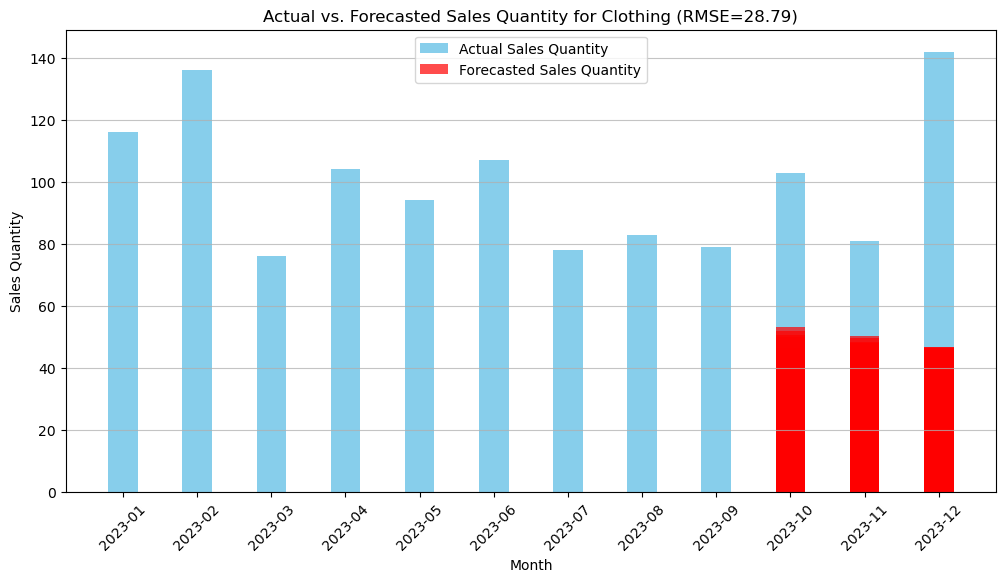

In [111]:
# Plot actual vs. forecasted sales quantity for Clothing using a bar chart
plt.figure(figsize=(12, 6))
width = 0.4  # Width of the bars

# Plot actual sales quantities
plt.bar(category_sales["month_str"], category_sales["sales_quantity"], width=width, color="skyblue", label="Actual Sales Quantity")

# Plot forecasted sales quantities for the entire year
plt.bar(category_sales["month_str"][train_size:], test_forecast, width=width, color="red", alpha=0.7, label="Forecasted Sales Quantity")

plt.title(f"Actual vs. Forecasted Sales Quantity for {category} (RMSE={rmse:.2f})")
plt.xlabel("Month")
plt.ylabel("Sales Quantity")
plt.legend()
plt.grid(axis="y", alpha=0.75)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.savefig("images/arima_forecast_sales_quantity_clothing.png")

C:\Users\a3588\AppData\Local\Temp\ipykernel_12556\4028868333.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=category_sales["date"].max() + pd.Timedelta(days=1), periods=forecast_steps, freq='M')


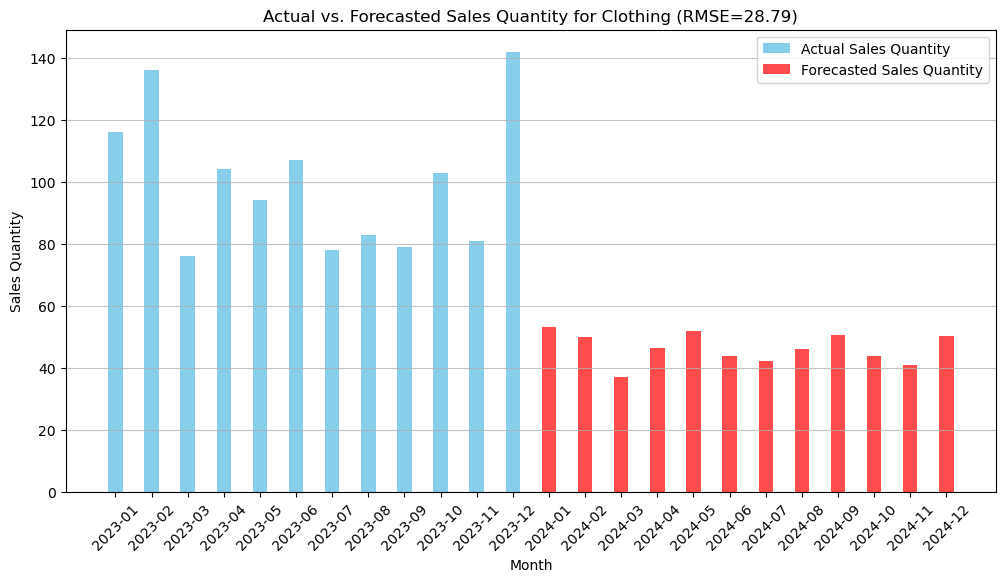

In [112]:
# Plot forecasted sales quantities for the entire year
forecast_steps = 12  # Number of months in a year
year_forecast = model_fit.forecast(steps=forecast_steps)

# Create a date range for the forecast
forecast_dates = pd.date_range(start=category_sales["date"].max() + pd.Timedelta(days=1), periods=forecast_steps, freq='M')
forecast_months = forecast_dates.to_period('M').astype(str)

# Plot actual vs. forecasted sales quantity for Clothing using a bar chart
plt.figure(figsize=(12, 6))
width = 0.4  # Width of the bars

# Plot actual sales quantities
plt.bar(category_sales["month_str"], category_sales["sales_quantity"], width=width, color="skyblue", label="Actual Sales Quantity")

# Plot forecasted sales quantities for the entire year
plt.bar(forecast_months, year_forecast, width=width, color="red", alpha=0.7, label="Forecasted Sales Quantity")

plt.title(f"Actual vs. Forecasted Sales Quantity for {category} (RMSE={rmse:.2f})")
plt.xlabel("Month")
plt.ylabel("Sales Quantity")
plt.legend()
plt.grid(axis="y", alpha=0.75)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.savefig("images/arima_forecast_sales_quantity_clothing_year.png")

In [113]:
# Build a model to predict when stock will run out for Home Goods category
category = "Home Goods"
category_data = df[df["category"] == category].copy()

# Group by date and sum sales quantity
category_sales = category_data.groupby("date")["sales_quantity"].sum().reset_index()

# Ensure the date column is in datetime format
category_sales["date"] = pd.to_datetime(category_sales["date"])

# Convert the date index to monthly periods
category_sales["month"] = category_sales["date"].dt.to_period('M')

# Convert the month column to strings
category_sales["month_str"] = category_sales["month"].astype("str")

# Calculate stock remaining at the end of each month
category_stock = category_data.groupby("date")["stock_remaining"].mean().reset_index()

# Ensure the date column is in datetime format
category_stock["date"] = pd.to_datetime(category_stock["date"])

# Convert the date index to monthly periods
category_stock["month"] = category_stock["date"].dt.to_period('M')

# Convert the month column to strings
category_stock["month_str"] = category_stock["month"].astype("str")

# Merge sales and stock data
category_data = category_sales.merge(category_stock, on="month_str", how="left")

# Set a maximum threshold for the cumulative sum to avoid overflow
max_threshold = 365 * 10  # 10 years in days
category_data["cumsum_stock_remaining"] = category_data["stock_remaining"].cumsum()
category_data["cumsum_stock_remaining"] = category_data["cumsum_stock_remaining"].clip(upper=max_threshold)

# Calculate the stockout date
category_data["stockout_date"] = category_data["date_x"] + pd.to_timedelta(category_data["cumsum_stock_remaining"], unit="D")

# Filter for rows where stock_remaining is 0
stockout_dates = category_data[category_data["stock_remaining"] == 0]

# Find the earliest stockout date
earliest_stockout_date = stockout_dates["stockout_date"].min()

# Print the earliest stockout date
print(f"Earliest stockout date for {category}: {earliest_stockout_date.date()}")

Earliest stockout date for Home Goods: NaT


In [114]:
# Build a model to predict when stock falls below 500 for Home Goods category.
category = "Home Goods"
category_data = df[df["category"] == category].copy()

# Group by date and sum sales quantity
category_sales = category_data.groupby("date")["sales_quantity"].sum().reset_index()

# Ensure the date column is in datetime format
category_sales["date"] = pd.to_datetime(category_sales["date"])

# Convert the date index to monthly periods
category_sales["month"] = category_sales["date"].dt.to_period('M')

# Convert the month column to strings
category_sales["month_str"] = category_sales["month"].astype("str")

# Calculate stock remaining at the end of each month
category_stock = category_data.groupby("date")["stock_remaining"].mean().reset_index()

# Ensure the date column is in datetime format
category_stock["date"] = pd.to_datetime(category_stock["date"])

# Convert the date index to monthly periods
category_stock["month"] = category_stock["date"].dt.to_period('M')

# Convert the month column to strings
category_stock["month_str"] = category_stock["month"].astype("str")

# Merge sales and stock data
category_data = category_sales.merge(category_stock, on="month_str", how="left")

# Calculate the cumulative stock remaining
category_data["cumsum_stock_remaining"] = category_data["stock_remaining"].cumsum()

# Define a threshold for low stock
low_stock_threshold = 500

# Find the first date when cumulative stock remaining falls below the threshold
stockout_date = category_data[category_data["cumsum_stock_remaining"] < low_stock_threshold]["date_x"].min()

# Print the stockout date
print(f"Earliest stockout date for {category}: {stockout_date}")

Earliest stockout date for Home Goods: 2023-01-01 00:00:00


In [115]:
# Build a model to predict when stock falls below 500 for Clothing category
category = "Clothing"
category_data = df[df["category"] == category].copy()

# Group by date and sum sales quantity
category_sales = category_data.groupby("date")["sales_quantity"].sum().reset_index()

# Ensure the date column is in datetime format
category_sales["date"] = pd.to_datetime(category_sales["date"])

# Convert the date index to monthly periods
category_sales["month"] = category_sales["date"].dt.to_period('M')

# Convert the month column to strings
category_sales["month_str"] = category_sales["month"].astype("str")

# Calculate stock remaining at the end of each month
category_stock = category_data.groupby("date")["stock_remaining"].mean().reset_index()

# Ensure the date column is in datetime format
category_stock["date"] = pd.to_datetime(category_stock["date"])

# Convert the date index to monthly periods
category_stock["month"] = category_stock["date"].dt.to_period('M')

# Convert the month column to strings
category_stock["month_str"] = category_stock["month"].astype("str")

# Merge sales and stock data
category_data = category_sales.merge(category_stock, on="month_str", how="left")

# Calculate the cumulative stock remaining
category_data["cumsum_stock_remaining"] = category_data["stock_remaining"].cumsum()

# Define a threshold for low stock
low_stock_threshold = 500

# Find the first date when cumulative stock remaining falls below the threshold
stockout_date = category_data[category_data["cumsum_stock_remaining"] < low_stock_threshold]["date_x"].min()

# Print the stockout date
print(f"Earliest stockout date for {category}: {stockout_date}")



Earliest stockout date for Clothing: 2023-01-01 00:00:00


In [116]:
# Time series analysis for a Product_1
product_id = "Product_1"
product_data = df[df["product_id"] == product_id].copy()

# Group by date and sum sales quantity
product_sales = product_data.groupby("date")["sales_quantity"].sum().reset_index()

# Ensure the date column is in datetime format
product_sales["date"] = pd.to_datetime(product_sales["date"])

# Convert the date index to monthly periods
product_sales["month"] = product_sales["date"].dt.to_period('M')

# Convert the month column to strings
product_sales["month_str"] = product_sales["month"].astype(str)

# Train-test split
train_size = int(len(product_sales) * 0.8)
train_sales = product_sales[:train_size]["sales_quantity"]
test_sales = product_sales[train_size:]["sales_quantity"]

# Function to evaluate ARIMA model
def evaluate_arima_model(train, test, arima_order):
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    rmse = np.sqrt(mean_squared_error(test, forecast))
    return rmse

# Grid search for ARIMA parameters
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)
best_score, best_cfg = float("inf"), None

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        rmse = evaluate_arima_model(train_sales, test_sales, (p, d, q))
        if rmse < best_score:
            best_score, best_cfg = rmse, (p, d, q)
    except:
        continue

print(f"Best ARIMA parameters for {product_id}: {best_cfg} with RMSE: {best_score:.2f}")

# Fit ARIMA model with best parameters
model = ARIMA(train_sales, order=best_cfg)
model_fit = model.fit()

# Forecast for the test period
test_forecast = model_fit.forecast(steps=len(test_sales))

# Calculate RMSE for the test period
rmse = np.sqrt(mean_squared_error(test_sales, test_forecast))

# Print RMSE
print(f"RMSE for ARIMA model on {product_id}: {rmse:.2f}")




c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters foun

Best ARIMA parameters for Product_1: (3, 2, 0) with RMSE: 3.17
RMSE for ARIMA model on Product_1: 3.17


c:\Users\a3588\anaconda3\envs\DebyWorkEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


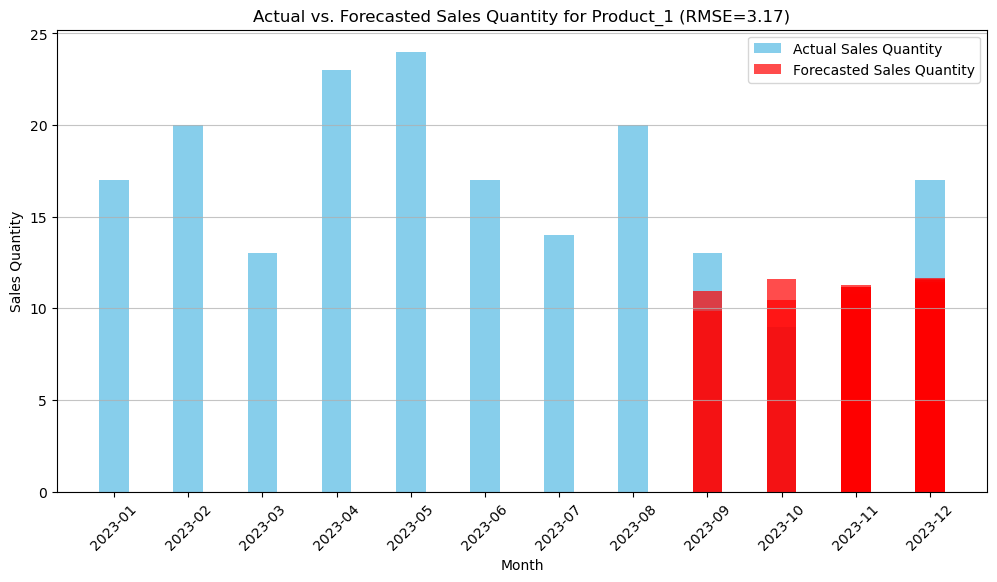

In [117]:
# Plot actual vs. forecasted sales quantity for a specific product using a bar chart
plt.figure(figsize=(12, 6))
width = 0.4  # Width of the bars

# Plot actual sales quantities
plt.bar(product_sales["month_str"], product_sales["sales_quantity"], width=width, color="skyblue", label="Actual Sales Quantity")

# Plot forecasted sales quantities for the entire year
plt.bar(product_sales["month_str"][train_size:], test_forecast, width=width, color="red", alpha=0.7, label="Forecasted Sales Quantity")

plt.title(f"Actual vs. Forecasted Sales Quantity for {product_id} (RMSE={rmse:.2f})")
plt.xlabel("Month")
plt.ylabel("Sales Quantity")
plt.legend()
plt.grid(axis="y", alpha=0.75)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.savefig("images/arima_forecast_sales_quantity_product_1.png")